# Bayesian Regression Example for ML w/ Prob Prog

Adapted from http://pyro.ai/examples/bayesian_regression_ii.html

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [2]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [3]:
rugged_data = pd.read_csv('rugged_data.csv', encoding='ISO-8859-1')

## Bayesian Linear Regression

Our goal is once again to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index, but we will explore more expressive guides.

## Model + Guide

We will write out the model again, similar to that in [Part I](bayesian_regression.ipynb), but explicitly without the use of `nn.Module`.  We will write out each term in the regression, using the same priors. `bA` and `bR` are regression coefficients corresponding to  `is_cont_africa` and `ruggedness`, `a` is the intercept, and `bAR` is the correlating factor between the two features.

Writing down a guide will proceed in close analogy to the construction of our model, with the key difference that the guide parameters need to be trainable. To do this we register the guide parameters in the ParamStore using `pyro.param()`. Note the positive constraints on scale parameters.

In [4]:
# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [5]:
def model(is_cont_africa, ruggedness, log_gdp):
    beta_0 = pyro.sample("beta_0", dist.Normal(0, 1))
    beta_1 = pyro.sample("beta_1", dist.Normal(0, 1))
    beta_2 = pyro.sample("beta_2", dist.Normal(0, 1))
    beta_3 = pyro.sample("beta_3", dist.Normal(0, 1))
    
    sigma = pyro.sample("sigma", dist.Gamma(1, 1))
    mean = beta_0 + \
           beta_1 * is_cont_africa + \
           beta_2 * ruggedness + \
           beta_3 * is_cont_africa * ruggedness
    
    with pyro.plate("data", len(log_gdp)):
        y = pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    
    return y

In [6]:
model(is_cont_africa, ruggedness, log_gdp)

tensor([ 7.4926,  8.2169,  9.9333,  9.4070,  7.7923,  9.2125, 10.1432, 10.2746,
         7.8520,  6.4324, 10.2148,  6.8661,  6.9062,  7.2992,  8.6960,  9.6758,
         9.7396,  8.5745,  8.4768,  8.6775,  7.7827,  8.8957,  9.6350,  8.9493,
         7.0458, 10.2142, 10.3143,  9.1177,  8.2760,  7.3624,  7.5405,  6.5053,
         6.8642,  8.7393,  7.4789,  8.4886,  9.0620,  9.9193,  9.6404, 10.1457,
         7.5401,  8.6881, 10.2664,  8.7657,  8.5975,  8.1237,  8.1882,  6.8155,
         9.9881,  9.1863,  6.4549, 10.1485,  8.5071, 10.1542,  8.7191, 10.1785,
         7.5393,  7.5458,  7.5887,  7.4548,  6.6625,  9.6284,  9.7638,  8.9275,
         8.2876,  8.3119, 10.1580,  7.8265,  9.1638,  7.4947,  9.4898,  8.0157,
         7.7895, 10.3265,  8.6702, 10.2726, 10.0799, 10.1264,  8.2026,  8.2550,
        10.1743,  8.4326,  6.9263,  7.3524,  7.5278,  9.3259,  9.6911,  9.6778,
         7.3588,  8.3467,  8.6342,  8.1958,  7.6604,  9.0788, 10.9646,  8.9751,
         9.8299,  8.1645,  7.1940,  6.71

In [7]:
log_gdp

tensor([ 7.4926,  8.2169,  9.9333,  9.4070,  7.7923,  9.2125, 10.1432, 10.2746,
         7.8520,  6.4324, 10.2148,  6.8661,  6.9062,  7.2992,  8.6960,  9.6758,
         9.7396,  8.5745,  8.4768,  8.6775,  7.7827,  8.8957,  9.6350,  8.9493,
         7.0458, 10.2142, 10.3143,  9.1177,  8.2760,  7.3624,  7.5405,  6.5053,
         6.8642,  8.7393,  7.4789,  8.4886,  9.0620,  9.9193,  9.6404, 10.1457,
         7.5401,  8.6881, 10.2664,  8.7657,  8.5975,  8.1237,  8.1882,  6.8155,
         9.9881,  9.1863,  6.4549, 10.1485,  8.5071, 10.1542,  8.7191, 10.1785,
         7.5393,  7.5458,  7.5887,  7.4548,  6.6625,  9.6284,  9.7638,  8.9275,
         8.2876,  8.3119, 10.1580,  7.8265,  9.1638,  7.4947,  9.4898,  8.0157,
         7.7895, 10.3265,  8.6702, 10.2726, 10.0799, 10.1264,  8.2026,  8.2550,
        10.1743,  8.4326,  6.9263,  7.3524,  7.5278,  9.3259,  9.6911,  9.6778,
         7.3588,  8.3467,  8.6342,  8.1958,  7.6604,  9.0788, 10.9646,  8.9751,
         9.8299,  8.1645,  7.1940,  6.71

In [8]:
def guide(is_cont_africa, ruggedness, log_gdp):
    weights_loc = pyro.param('weights_loc', torch.randn(4))
    weights_scale = pyro.param('weights_scale', torch.ones(4), constraint=constraints.positive)        
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=constraints.positive)
    
    beta_0 = pyro.sample("beta_0", dist.Normal(weights_loc[0], weights_scale[0]))
    beta_1 = pyro.sample("beta_1", dist.Normal(weights_loc[1], weights_scale[1]))
    beta_2 = pyro.sample("beta_2", dist.Normal(weights_loc[2], weights_scale[2]))
    beta_3 = pyro.sample("beta_3", dist.Normal(weights_loc[3], weights_scale[3]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    
    mean = beta_0 + \
           beta_1 * is_cont_africa + \
           beta_2 * ruggedness + \
           beta_3 * is_cont_africa * ruggedness

In [9]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

## SVI

As before, we will use SVI to perform inference.

In [10]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
num_iters = 10000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

/Users/alp/.virtualenvs/pp/lib/python3.7/site-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  after removing the cwd from sys.path.
/Users/alp/.virtualenvs/pp/lib/python3.7/site-packages/ipykernel_launcher.py:10: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  # Remove the CWD from sys.path while we load stuff.
/Users/alp/.virtualenvs/pp/lib/python3.7/site-packages/ipykernel_launcher.py:13: TracerWarning: Converting a tensor to a Python index might

In [11]:
svi_diagnorm_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)

Let us observe the posterior distribution over the different latent variables in the model.

In [12]:
sites = ["beta_0", "beta_1", "beta_2", "beta_3", "sigma"]

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}

for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta_0
       mean       std        5%       25%      50%       75%       95%
0  9.014088  0.073364  8.897592  8.961958  9.01332  9.064412  9.140697 

Site: beta_1
       mean       std        5%       25%       50%       75%       95%
0 -1.662646  0.137336 -1.887685 -1.760969 -1.661473 -1.564835 -1.439959 

Site: beta_2
       mean       std        5%      25%       50%       75%       95%
0 -0.112141  0.042307 -0.182401 -0.13952 -0.112008 -0.081139 -0.042913 

Site: beta_3
       mean       std        5%       25%       50%       75%       95%
0  0.279758  0.077828  0.147726  0.230267  0.277731  0.329188  0.407633 

Site: sigma
       mean       std        5%       25%      50%       75%       95%
0  0.941949  0.049581  0.858192  0.909664  0.94374  0.975215  1.020062 



## HMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using [Markov Chain Monte Carlo](http://docs.pyro.ai/en/dev/mcmc.html) (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS) \[1\], which provides an efficient and automated way of running Hamiltonian Monte Carlo.  It is slightly slower than variational inference, but provides an exact estimate.

In [13]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [00:25<00:00, 46.49it/s, step size=5.55e-01, acc. prob=0.903]


In [14]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta_0
       mean       std        5%       25%       50%       75%       95%
0  9.006353  0.145196  8.772644  8.911474  9.007591  9.102889  9.251899 

Site: beta_1
       mean       std        5%       25%      50%       75%       95%
0 -1.680382  0.213722 -2.030094 -1.826043 -1.68679 -1.530283 -1.324081 

Site: beta_2
       mean      std        5%       25%       50%       75%       95%
0 -0.106478  0.07904 -0.240789 -0.162316 -0.106674 -0.054379  0.029269 

Site: beta_3
       mean       std       5%       25%       50%       75%       95%
0  0.276406  0.118397  0.08238  0.196398  0.277487  0.359303  0.464629 

Site: sigma
      mean       std        5%       25%       50%       75%       95%
0  0.95503  0.054514  0.865594  0.917371  0.952679  0.991365  1.046138 



## Comparing Posterior Distributions

Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the *KL(q||p)* loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

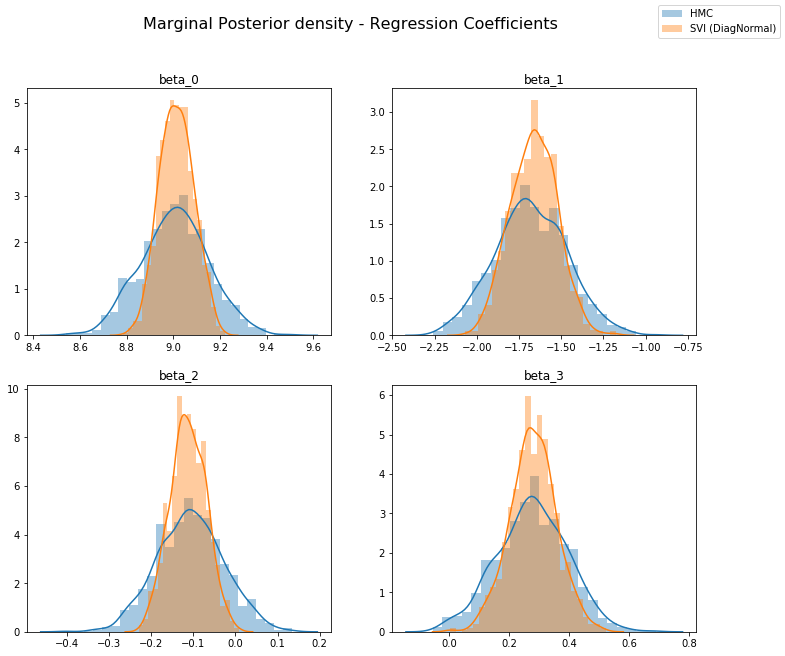

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = sites[i]
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
        ax.set_title(site)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

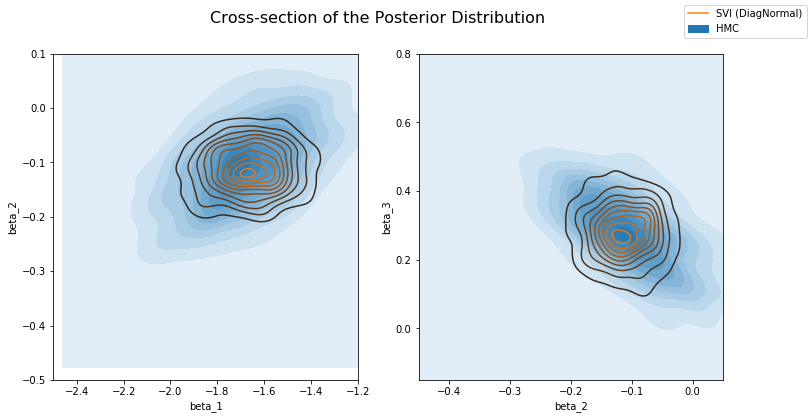

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["beta_1"], hmc_samples["beta_2"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_samples["beta_1"], svi_samples["beta_2"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="beta_1", ylabel="beta_2", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["beta_2"], hmc_samples["beta_3"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_samples["beta_2"], svi_samples["beta_3"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="beta_2", ylabel="beta_3", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal Guide

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution.  This allows us to capture the correlations between the latent variables via a covariance matrix.  If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [17]:
from pyro.infer.autoguide.initialization import init_to_mean

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=Trace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 100148.57491639256
Elbo loss: 2174.9007269740105
Elbo loss: 1228.360510289669
Elbo loss: 1792.672747194767
Elbo loss: 629.9744652509689
Elbo loss: 864.029569029808
Elbo loss: 454.2743031978607
Elbo loss: 641.9886850118637
Elbo loss: 712.8340665698051
Elbo loss: 524.0327571630478
Elbo loss: 509.02528899908066
Elbo loss: 736.6811172962189
Elbo loss: 533.3716480731964
Elbo loss: 513.46073782444
Elbo loss: 450.8168035745621
Elbo loss: 532.2072778940201
Elbo loss: 506.3982683420181
Elbo loss: 486.563796877861
Elbo loss: 478.4416654109955
Elbo loss: 404.9021246433258


We will discuss why we are rerunning this optimization again later in class.

In [19]:
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 344.63232135772705
Elbo loss: 386.06641536951065
Elbo loss: 353.6212839484215
Elbo loss: 327.7295082807541
Elbo loss: 289.90510289371014
Elbo loss: 287.482987113297
Elbo loss: 294.10035656392574
Elbo loss: 283.8595420476049
Elbo loss: 284.76177279651165
Elbo loss: 284.91842363774776
Elbo loss: 295.28635132312775
Elbo loss: 285.2734457924962
Elbo loss: 283.5001142770052
Elbo loss: 285.61036701500416
Elbo loss: 284.3071924895048
Elbo loss: 285.0442218258977
Elbo loss: 285.32616828754544
Elbo loss: 284.9674888588488
Elbo loss: 284.25893741846085
Elbo loss: 284.7123777978122


Let's look at the shape of the posteriors again.  You can see the multivariate guide is able to capture more of the true posterior.

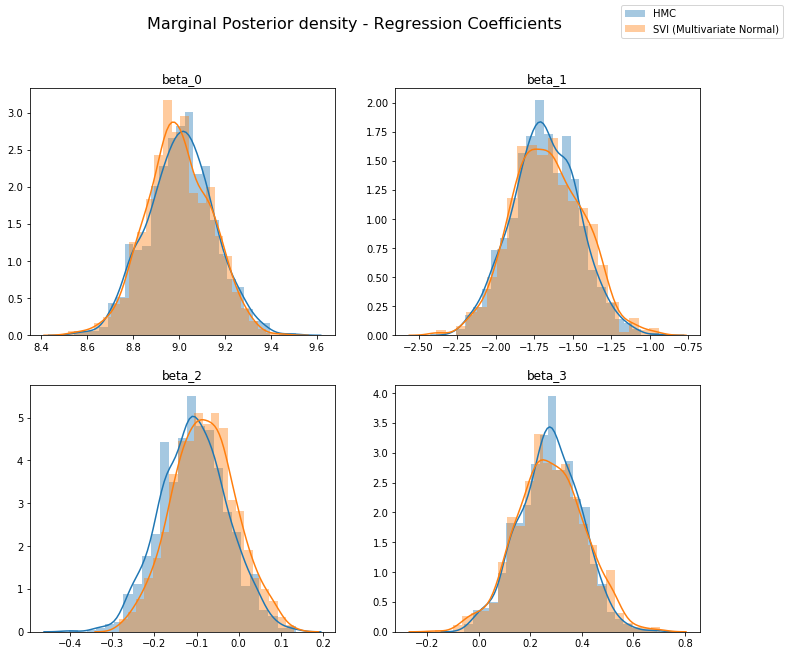

In [20]:
svi_mvn_posterior = svi.run(log_gdp, is_cont_africa, ruggedness)
svi_mvn_samples = {site: EmpiricalMarginal(svi_mvn_posterior, sites=site).enumerate_support()
                         .detach().cpu().numpy()
                   for site in sites}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = sites[i]
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
        ax.set_title(site)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

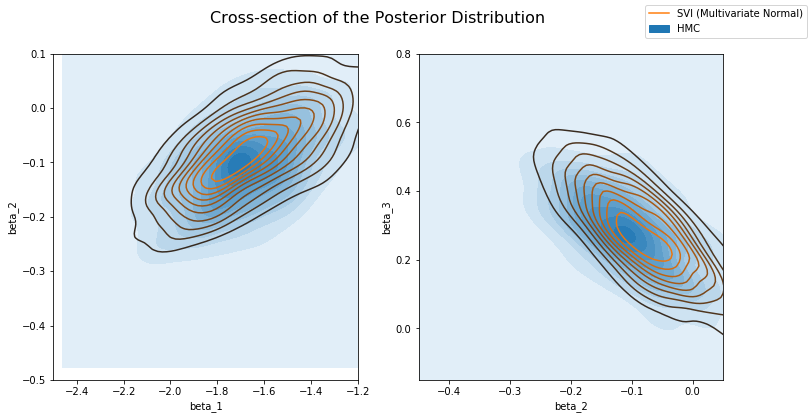

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["beta_1"], hmc_samples["beta_2"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["beta_1"], svi_mvn_samples["beta_2"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="beta_1", ylabel="beta_2", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["beta_2"], hmc_samples["beta_3"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["beta_2"], svi_mvn_samples["beta_3"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="beta_2", ylabel="beta_3", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## References
[1] Hoffman, Matthew D., and Andrew Gelman. "The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.  https://arxiv.org/abs/1111.4246.